# Kommentaaride süntees

See notebook sisaldab loogikat ja koodi selleks, et male käigu `string` põhjal sünteesida kommentaar, milline käik aset võttis.

Käigu kirjelduse sisendiks on käigu alguse ruut ja käigu lõpu ruut.<br>
Formaat: `<alguse täht><alguse nr><lõpp täht><lõpp nr>`<br>
Näiteks: `g1f3`

<b>Hetkene idee:</b>
- Eeldame, et käik on valideeritud
- Peale käigu tegemist..
    - ..kontrolli mängu seisu
    - ..vaata mis nupp liigub
    - ..vaata kust kuhu liigutakse
    - ..vaata kas mõni nupp võeti ära
    - ..kontrolli kas antakse tuld

In [1]:
import chess
import json
import requests
import IPython.display as ipd
import re

## Male laua kasutamine ja set-up

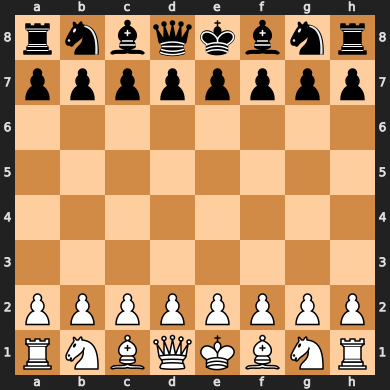

In [2]:
# Laua paika panemine
board = chess.Board()

board

Kasulik termin: <b>pseudo-legal</b> käik - <i>"Pseudo-legal moves might leave or put the king in check, but are otherwise valid. Null moves are not pseudo-legal. Castling moves are only included if they are completely legal."</i>

Kasulikud käsud:
- `board.push_uci("g1f3")` - tee käik g1 -> f3 (ei kontrolli valiidsust)
- `board.pop()` - võta viimane käik tagasi ja tagasta see
- `board.is_capture(move)` - tagastab bool, et kas pseudo-legal käik võtab nupu
- `board.is_check()` - tagastab bool, et kas praegu käiv pool on tule all
- `board.piece_at(square)` - tagastab ruudul oleva nupu
- `board.piece_type_at(sqsuare)` - tagastab ruudul oleva nupu tüübi
- `board.color_at(square)` - tagastab ruudul oleva nupu värvi
- `board.peek()` - tagastab viimase käigu
- `board.turn` - tagastab True kui on valge käik

## Neurokõne

Käigu `string` põhjal saab genereerida neurokõne, mis kommenteerib tehtud käiku.

Erinevad lause struktuurid mida kasutada:
- `<mängija värv>` `<nupp>` käis ruudult `<algus ruut>` ruudule `<lõpu ruut>`.
- `<mängija värv>` võttis ära `<vastase värvi>` `<võetud nupp>`.
- `<mängija värv>` annab `<vastase värvile>` tuld.
- `<mängija värv>` võitis mängu.
- Mäng jäi viiki.

In [7]:
piecesNames = {"P":"Valge ettur", "N":"Valge ratsu", "B":"Valge oda",
          "R":"Valge vanker", "Q":"Valge lipp", "K":"Valge kuningas",
          "p":"Must ettur", "n":"Must ratsu", "b":"Must oda",
          "r":"Must vanker", "q":"Must lipp", "k":"Must kuningas"}
takenPieces = {"P":"Valge etturi", "N":"Valge ratsu", "B":"Valge oda",
          "R":"Valge vankri", "Q":"Valge lipu", "K":"Valge kuninga",
          "p":"Musta etturi", "n":"Musta ratsu", "b":"Musta oda",
          "r":"Musta vankri", "q":"Musta lipu", "k":"Musta kuninga"}


def generateVoiceover(text):
    payload = {'text': text, 'speaker': 'Albert'}
    headers = {"Content-Type": "application/json"};
    response = requests.post("https://api.tartunlp.ai/text-to-speech/v2", data=json.dumps(payload), headers=headers)
    return response.content


def playVoiceover(board):
    try:
        return ipd.Audio(data=generateVoiceover(buildComment(board)), autoplay=True)
    except:
        print("Kommentaari sünteesimine ebaõnnestus!")

def resolveOutcomeComment(outcome):
    winner = outcome.winner
    if winner is None:
        return "Mäng jäi viiki."
    elif winner:
        return "Valge võitis mängu."
    else:
        return "Must võitis mängu."

    
def describeMoveComment(board, move):
    piece = board.piece_at(move.to_square)
    result = piecesNames[piece.symbol()]
    result += " käis ruudult "
    result += chess.square_name(move.from_square)
    result += " ruudule "
    result += chess.square_name(move.to_square)
    return result


def describeTakenPiece(board, move):
    result = ""
    board.pop()
    takenPiece = board.piece_at(move.to_square)
    if takenPiece is not None:
        if board.turn:
            result = "Valge võttis ära " + takenPieces[takenPiece.symbol()]
        else:
            result = "Must võttis ära " + takenPieces[takenPiece.symbol()]
    board.push(move)
    return result


def describeCheck(board):
    result = ""
    if board.is_check():
        if board.turn:
            result = "Must annab valgele tuld."
        else:
            result = "Valge annab mustale tuld."
    return result


# MAIN METHOD
# - Assumes the move has already been made
# - Assues it is still the turn of the player who made the move
def buildComment(board):
    # Variables
    result = ""
    move = board.peek()
    outcome = board.outcome()
    isOngoing = True
    
    # Describe outcome if any
    if (outcome is not None): # game has ended
        result += resolveOutcomeComment(outcome) + " "
        isOngoing = False
    
    # Describe move
    result += describeMoveComment(board, move) + ". "
    
    # Check and describe taken pieces
    result += describeTakenPiece(board, move) + ". "
    
    # Check for check
    if (isOngoing):
        result += describeCheck(board)
    
    return result

Valge ettur käis ruudult e2 ruudule e4. . 



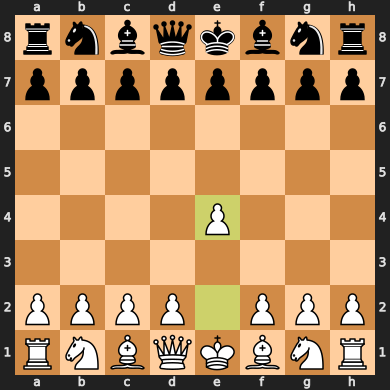

- - - - - - - - - - - - - - - - - - - - - - - - - -
Must ettur käis ruudult e7 ruudule e5. . 



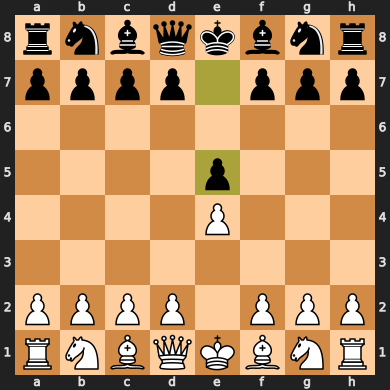

- - - - - - - - - - - - - - - - - - - - - - - - - -
Valge oda käis ruudult f1 ruudule c4. . 



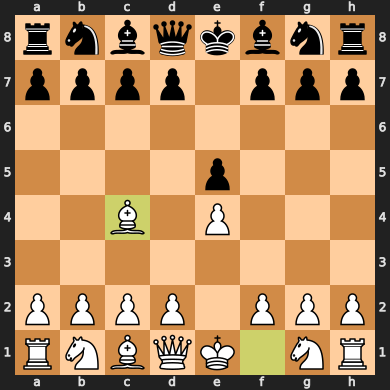

- - - - - - - - - - - - - - - - - - - - - - - - - -
Must ratsu käis ruudult b8 ruudule c6. . 



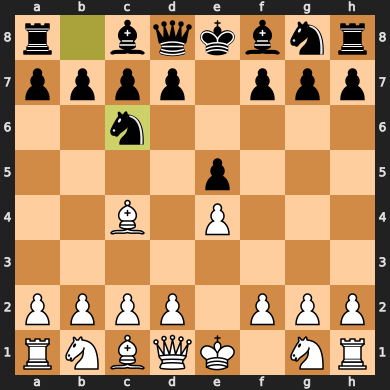

- - - - - - - - - - - - - - - - - - - - - - - - - -
Valge lipp käis ruudult d1 ruudule h5. . 



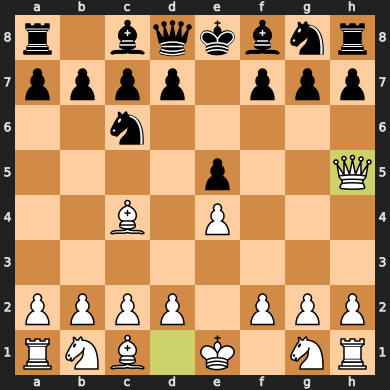

- - - - - - - - - - - - - - - - - - - - - - - - - -
Must ratsu käis ruudult g8 ruudule f6. . 



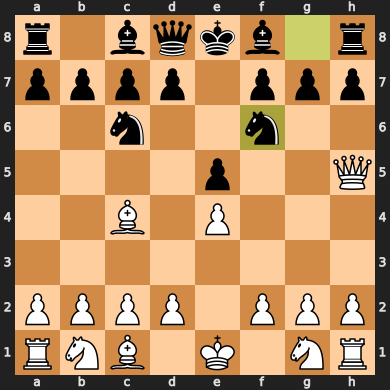

- - - - - - - - - - - - - - - - - - - - - - - - - -
Valge oda käis ruudult c4 ruudule f7. Valge võttis ära Musta etturi. Valge annab mustale tuld.



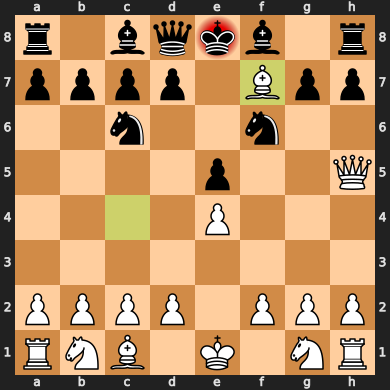

- - - - - - - - - - - - - - - - - - - - - - - - - -


In [8]:
# Simple demo

# Check-mate demo
#moves = ["e2e4", "e7e5", "f1c4", "b8c6", "d1h5", "g8f6", "h5f7"]
# Check demo
moves = ["e2e4", "e7e5", "f1c4", "b8c6", "d1h5", "g8f6", "c4f7"]

board.reset()

for m in moves:
    board.push_uci(m)
    print(buildComment(board)+"\n")
    #print(board)
    display(board)
    print("- - - - - - - - - - - - - - - - - - - - - - - - - -")

playVoiceover(board)

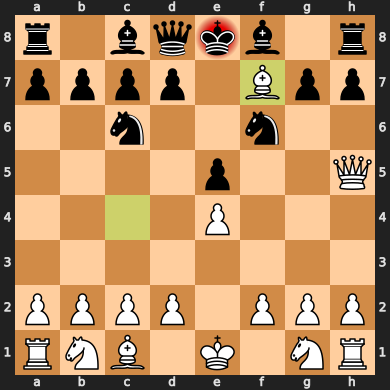

In [5]:
board

## Käigu tõlgendamise katsed

Siin on katsetused proovida kasutaja sisestatud lausest genereerida vastav käik. Eeldatakse, et mängija suudab ise tuvastada millised on võimalikud käigud. Käigu valiidsust kontrollitakse, ning segaduse korral küsitakse üle. Käigu tõlgendamisel tehakse eeldus formaadi osas.

Sisestatud käigu formaat peab olema üks järgnevatest:
- Sisaldab täpselt kahte laua ruutu, millest esimene on alguskoht ja teine sihtkoht
- Sisaldab täpselt ühte laua ruutu ja nupu nimetust, mis sinna ruutu proovib käia

In [6]:
def findConfidence(text):
    conf = 0
    
    question = re.search("(kas|kuidas|kuhu|miks|millal)", text)
    if question is not None: # Questions not accepted
        conf -= 0.5
        
    squares = re.findall("[a-h]{1}[1-8]{1}", text)
    if len(squares) > 0: # Assumed target square
        conf += 0.5
        if len(squares) > 1: # Assumed source square
            conf += 0.4
            if len(squares) > 2: # Too many squares
                conf -= 1.0
        
    piece = re.search("(ettur|vank|ratsu|oda|lip|kuning)", text)
    if piece is not None and len(squares) == 1:
        conf += 0.4
    elif piece is not None and len(squares) > 1: # Too much info
        conf -= 1.0
    
    return conf

def checkMoveLegality(board, move):
    if move in board.legal_moves:
        return True
    else:
        return False
    
def getSourceSquareFromPiece(board, text):
    piece = getPiece(text)
    # TODO - Finish getting the source square based on piece
    # - Will require checking all possible player pieces on the board,
    #   which could possibly move onto target square.
            
def getPiece(text):
    piece = re.search("ettur", text)
    if piece is not None:
        piece = 1
        return piece
    piece = re.search("ratsu", text)
    if piece is not None:
        piece = 2
        return piece
    piece = re.search("oda", text)
    if piece is not None:
        piece = 3
        return piece
    piece = re.search("vank", text)
    if piece is not None:
        piece = 4
        return piece
    piece = re.search("lip", text)
    if piece is not None:
        piece = 5
        return piece
    piece = re.search("kuning", text)
    if piece is not None:
        piece = 6
        return piece
    return piece

def interpretInput(board, text, confMin = 0.8, output = True):
    text = text.lower()
    if (findConfidence(text) < confMin):
        if output:
            print("Sisend ei ole sobilik.")
        return
    
    squares = re.findall("[a-h]{1}[1-8]{1}", text)
    if len(squares > 1):
        move = chess.Move.from_uci(squares[0] + squares[1])
        if not checkMoveLegality(board, move):
            if output:
                print("Sellist käiku pole võimalik teha.")
            return
        return move
    else:
        move = chess.Move.from_uci(getSourceSquareFromPiece(board, text) + squares[0])
        # TODO - Finish this method